## Experiment 5 h (step size)
Add noise to the gradient.

In [2]:
! pip install qujax

  Using cached qujax-1.1.0-py3-none-any.whl.metadata (11 kB)
  Using cached jax-0.4.26-py3-none-any.whl.metadata (23 kB)
  Using cached jaxlib-0.4.26-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached ml_dtypes-0.4.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
Using cached qujax-1.1.0-py3-none-any.whl (25 kB)
Using cached jax-0.4.26-py3-none-any.whl (1.9 MB)
Using cached jaxlib-0.4.26-cp311-cp311-manylinux2014_x86_64.whl (78.8 MB)
Using cached ml_dtypes-0.4.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)


In [3]:
import pickle
with open(f'./numerical_sim/bi_gaussain/gen_data.pkl', 'rb') as file:
    data = pickle.load(file)

In [6]:
## Plot function 
def plot_histogram_and_line(data, final_st):
    fig, ax = plt.subplots()
    
    # Plot histogram for data
    ax.hist(data, bins=50, density=True, alpha=0.5, label="Data")
    
    # Plot line for Final Parameter
    ax.plot(final_st, label="Final Parameter", color='orange')
    
    # Plot line for Averaged over parameters
   # ax.plot(data_avg, label="Averaged over parameters", linestyle='--', color='orange')
    
    # Adjust plot settings
    ax.set_xlim(data.min(), data.max())
    ax.set_ylabel("Probability")
    ax.set_xlabel("Data $\mu$m")
    ax.legend()
    
    return fig

## Simulation functions
def expected_kernel(kernel, data1, weights1, data2, weights2):
    from jax import numpy as jnp, random, vmap, grad, value_and_grad, jit

    def row_eval(data1_single):
        return (vmap(kernel, in_axes=(None, 0))(data1_single, data2) * weights2).sum()

    return (vmap(row_eval)(data1) * weights1).sum()


def mmd(kernel, data1, weights1, data2, weights2):

    return (
        expected_kernel(kernel, data1, weights1, data1, weights1)
        - 2 * expected_kernel(kernel, data1, weights1, data2, weights2)
        + expected_kernel(kernel, data2, weights2, data2, weights2)
    )

def get_stepsize( step):
    return (step + 10) **(-1/3)

def get_circuit(n_qubits, depth):
    n_params = 2 * n_qubits * (depth + 1)

    gates = ["H"] * n_qubits + ["Rx"] * n_qubits + ["Ry"] * n_qubits
    qubit_inds = [[i] for i in range(n_qubits)] * 3
    param_inds = [[]] * n_qubits + [[i] for i in range(n_qubits * 2)]

    k = 2 * n_qubits

    for _ in range(depth):
        for i in range(0, n_qubits - 1):
            gates.append("CZ")
            qubit_inds.append([i, i + 1])
            param_inds.append([])
        for i in range(n_qubits):
            gates.append("Rx")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
        for i in range(n_qubits):
            gates.append("Ry")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
    return gates, qubit_inds, param_inds, n_params


def gaussian_kernel(s1, s2, bandwidth_sq):
    return jnp.exp(-jnp.square(s1 - s2) / bandwidth_sq)

def param_to_mmd(param, param_to_st):
    from jax import numpy as jnp
    st = param_to_st(param)
    probs = jnp.square(jnp.abs(st.flatten()))
    return mmd(lambda s1, s2: gaussian_kernel(s1, s2, bandwidth_sq), jnp.arange(st.size), probs, data, data_probs)


def param_to_mmd_stochastic(param, param_to_st, batch_size):
    data_probs = jnp.ones(batch_size) / batch_size
    st = param_to_st(param)
    probs = jnp.square(jnp.abs(st.flatten()))
    return mmd(lambda s1, s2: gaussian_kernel(s1, s2, bandwidth_sq), jnp.arange(st.size), probs, np.random.choice(data, batch_size), data_probs)

def compute_av_probs(params, param_to_st, burn_in = 100):
    from jax import numpy as jnp, vmap
    probs = vmap(lambda p: jnp.square(jnp.abs(param_to_st(p).flatten())))(params[burn_in:])
    return probs.mean(axis=0)


In [7]:

def G(p, params_for_sgada):
    from jax import numpy as jnp
    import numpy as np
    M, M_inv, mu_inv, N_d, kBT, sigma, sigma_a, _ = params_for_sgada
    return mu_inv * (p.T @ M_inv @ p - N_d * kBT)

def A_step(q,p,xi,h, params_for_sgada):
    from jax import numpy as jnp
    import numpy as np
    M, M_inv, mu_inv, N_d, kBT, sigma, sigma_a, _ = params_for_sgada
    q = q + h * M_inv @ p
    return q,p,xi

def B_step(q,p,xi,h,force, params_for_sgada):
    p = p + h * force(q) 
    return q,p,xi

def O_step(q,p,xi,h, params_for_sgada):
    from jax import numpy as jnp
    import numpy as np
    M, M_inv, mu_inv, N_d, kBT, sigma, sigma_a, _ = params_for_sgada
    
    term1 = np.exp(-xi*h) * p
    term2 = sigma_a * np.sqrt((1 - np.exp(-2 * xi * h)) / (2 * xi)) * np.random.randn(p.shape[0])
    p = term1 + term2
    return q,p,xi

def D_step(q,p,xi,h, params_for_sgada):
    from jax import numpy as jnp
    import numpy as np
    xi = xi + h * G(p, params_for_sgada)
    return q,p,xi

def ld_BADODAB(q,p,xi,h,force, params_for_sgada):

    q, p, xi = np.copy(q), np.copy(p), np.copy(xi)
    q, p, xi = B_step(q,p,xi,h/2,force,params_for_sgada)
    q, p, xi = A_step(q,p,xi,h/2, params_for_sgada)
    q, p, xi = D_step(q,p,xi,h/2, params_for_sgada)
    q, p, xi = O_step(q,p,xi,h,   params_for_sgada)
    q, p, xi = D_step(q,p,xi,h/2, params_for_sgada)
    q, p, xi = A_step(q,p,xi,h/2, params_for_sgada)
    q, p, xi = B_step(q,p,xi,h/2,force, params_for_sgada)

    return q, p, xi


In [8]:
def run_simulation_SGAdL(alpha, q0, p0, xi0,step_function,force,hyperparameters,train_keys):
    #q0, p0, xi0, Nsteps, h, step_function, force):
    h, M, mu_inv, N_d, beta, sigma, sigma_a, n_steps, n_qubits, circuit_depth, batch_size = hyperparameters.values()

    bar_length = 30
    
    q_traj = [q0]
    p_traj = [p0]
    xi_traj = [xi0]
    cost_vals = []

    q = q0
    p = p0
    xi = xi0

    M_inv = M
    kBT     = 1 / beta
    params_for_sgada = (M, M_inv, mu_inv, N_d, kBT, sigma, sigma_a, batch_size)

    
    start_time = time.time()  # Record the start time

    for n in range(n_steps):
        
        cost_val, cost_grad = param_to_mmd_and_grad(q_traj[n - 1])

        # Add noise to the cost_grad
        noise = random.normal(train_keys[n - 1], shape=cost_grad.shape, dtype=jnp.float32)
        cost_grad = cost_grad + alpha * noise
        
        
        q,p,xi = step_function(q, p, xi, h, force, params_for_sgada)

        cost_vals.append(cost_val)
        

        q_traj += [q]
        p_traj += [p]
        xi_traj += [xi]
        
        progress = (n+1) / n_steps
        filled_length = int(bar_length * progress)
        bar = '█' * filled_length + '-' * (bar_length - filled_length)
        
        elapsed_time = time.time() - start_time  # Compute the elapsed time
        remaining_time = (elapsed_time / (n + 1)) * (n_steps - n - 1)  # Estimate the remaining time

        
        print(f'\rProgress: |{bar}| {progress:.2%} | Iteration: {n+1}/{n_steps} | Cost: {cost_val:.6f} | Elapsed Time: {elapsed_time:.2f}s | Estimated Remaining Time: {remaining_time:.2f}s', end='')    
    print()  # Move to the next line after the progress bar
    
    total_run_time = time.time() - start_time  # Compute the total run time
    
    return q_traj, p_traj, xi_traj, cost_vals, total_run_time

In [9]:
def run_simulation_SGLD(alpha,init_param,n_params,hyperparameters,train_keys):
    import time
    h,beta, n_steps, n_qubits, circuit_depth, batch_size = hyperparameters.values()

    bar_length = 30

    params = jnp.zeros((n_steps, n_params))
    params = params.at[0].set(init_param)

    cost_vals = jnp.zeros(n_steps - 1)

    start_time = time.time() # Record the start time

    # compute before the loop as they are reused
    gamma = jnp.sqrt(2*h/ beta)

    for step in range(1, n_steps):
        cost_val, cost_grad = param_to_mmd_and_grad(params[step - 1])
        
        # Add noise to the cost_grad
        noise = random.normal(train_keys[step - 1], shape=cost_grad.shape, dtype=jnp.float32)
        cost_grad = cost_grad + alpha * noise
        

        cost_vals = cost_vals.at[step - 1].set(cost_val)

        # stepsize = get_stepsize(step)

        new_param = (
            params[step - 1]
            - h * cost_grad
            + gamma
            * random.normal(train_keys[step - 1], shape=(n_params,))
        )
        params = params.at[step].set(new_param)

        progress = (step+1) / n_steps
        filled_length = int(bar_length * progress)
        bar = '█' * filled_length + '-' * (bar_length - filled_length)
        elapsed_time = time.time() - start_time # Compute the elapsed time
        remaining_time = (elapsed_time / step) * (n_steps - step) # Estimate the remaining time
        print(f'\rProgress: |{bar}| {progress:.2%} | Iteration: {step}/{n_steps} | Cost: {cost_val:.6f} | Elapsed Time: {elapsed_time:.2f}s | Estimated Remaining Time: {remaining_time:.2f}s', end='')

    print() # Move to the next line after the progress bar

    total_run_time = time.time() - start_time # Compute the total run time

    return params, cost_vals, total_run_time

In [10]:
from jax import numpy as jnp, random, vmap, grad, value_and_grad, jit
import matplotlib.pyplot as plt
import qujax
import jax
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import os

In [6]:
output_folder = "experiment_5"
h_range = [0.01, 0.05, 0.1, 0.5, 1.0]
stochastic_flag = True
qubit = 8
depth = 4
n_qubits = 8
circuit_depth = 4
beta = 100
alpha = 0
n_steps = 5000
batch_size= 200

random_key = random.PRNGKey(0)
init_key, train_key = random.split(random_key)
bandwidth_sq = 5.7478714  # jnp.median(dist_mat) / 2
init_rad = 0.001 / jnp.pi

for h_step_size in h_range:
    print(f"Running experiment for h_step_size={h_step_size}")
    
    sgadl_hyperparams = {
        'h': h_step_size, 'M': None, 'mu_inv': 1., 'N_d': 1., 'beta': beta, 'sigma': 1., 'sigma_a': 1.00,
        'n_steps': n_steps, 'n_qubits': qubit, 'circuit_depth': None, 'batch_size': batch_size
    }
    
    sgld_hyperparams = {
        'h': h_step_size, 'beta': beta, 'n_steps': n_steps, 'n_qubits': qubit, 'circuit_depth': depth, 'batch_size': batch_size
    }
    
    gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
    param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
    data_probs = jnp.ones(len(data)) / len(data)
    
    if stochastic_flag:
        param_to_mmd_and_grad = jit(value_and_grad(lambda param: param_to_mmd_stochastic(param, param_to_st, batch_size)))
    else:
        param_to_mmd_and_grad = jit(value_and_grad(lambda param: param_to_mmd(param, param_to_st)))
    
    train_keys = random.split(train_key, sgld_hyperparams['n_steps'] - 1)
    
    init_param = random.uniform(
        init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
    )
    
    # Update hyperparameters with the current n_qubits and circuit_depth
    sgadl_hyperparams['M'] = jnp.eye(n_params)
    
    # Run SGLD model
    sgld_output, sgld_cost_vals, sgld_run_time = run_simulation_SGLD(
        alpha, init_param, n_params, sgld_hyperparams, train_keys
    )
    
    # Run SGADA model
    sgada_output, sgada_p_traj, sgada_xi_traj, sgada_cost_vals, sgada_total_run_time = run_simulation_SGAdL(
        alpha, init_param, np.random.randn(n_params), 0.0, ld_BADODAB, (lambda q: -param_to_mmd_and_grad(q)[1]), sgadl_hyperparams, train_keys
    )
    
    model_SGAdL = {
        'params': sgada_output,
        'cost_vals': sgada_cost_vals,
        'run_time': sgada_total_run_time,
        'p_traj': sgada_p_traj,
        'xi_traj': sgada_xi_traj
    }
    
    model_SGLD = {
        'params': sgld_output,
        'cost_vals': sgld_cost_vals,
        'run_time': sgld_run_time,
    }
    
    # Save results to files
    filename = f"results_h_{h_step_size}.pkl"
    filepath = os.path.join(output_folder, filename)
    
    results = {
        'h_step_size': h_step_size,
        'sgld': model_SGLD,
        'sgadl': model_SGAdL
    }
    
    with open(filepath, 'wb') as f:
        pickle.dump(results, f)
    
    print(f"Results saved to {filepath}")

Running experiment for h_step_size=0.01


NameError: name 'get_circuit' is not defined

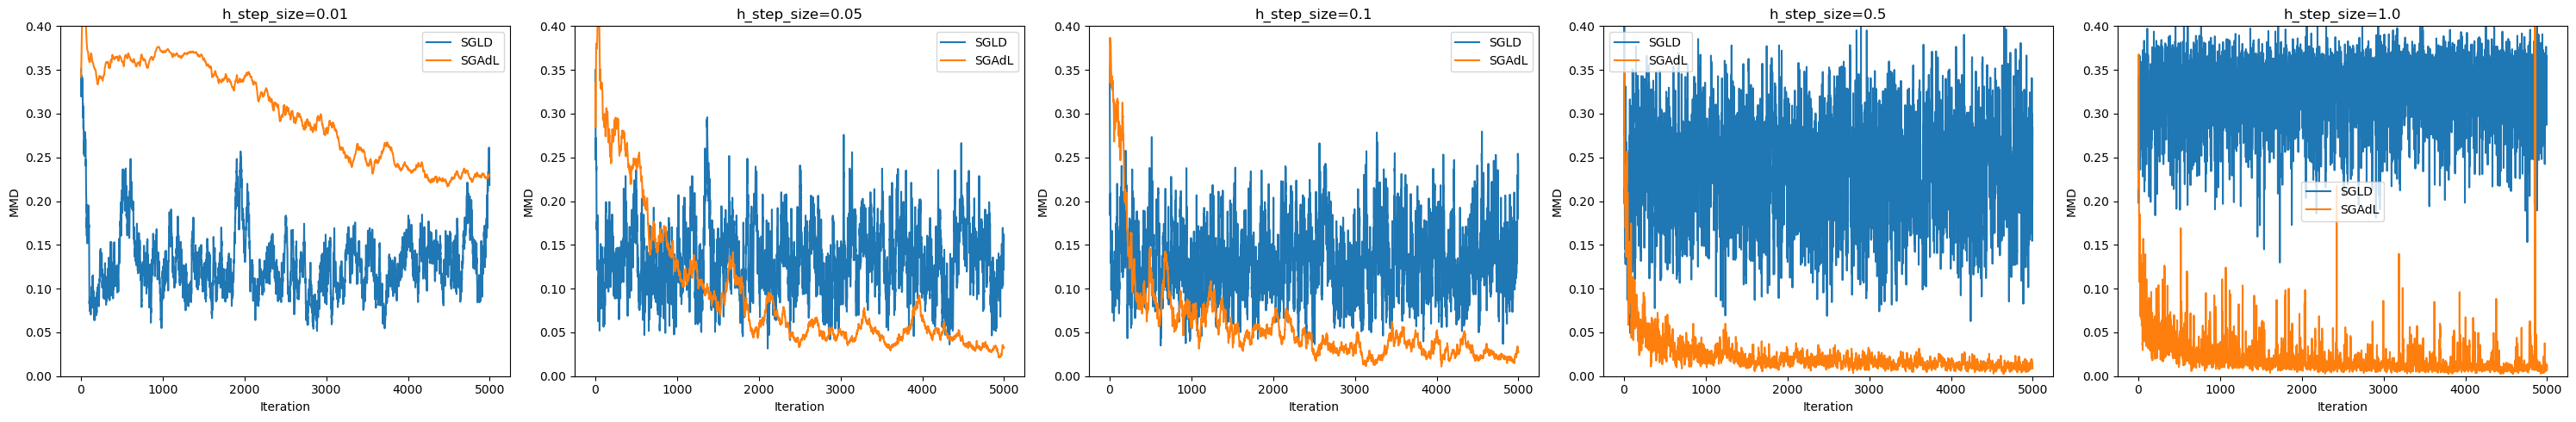

In [16]:
import os
import pickle
import matplotlib.pyplot as plt

output_folder = "experiment_5"
h_range = [0.01, 0.05, 0.1, 0.5, 1.0]
stochastic_flag = True
qubit = 8
depth = 4
n_qubits = 8
circuit_depth = 4
beta = 100
alpha = 0
n_steps = 5000
batch_size = 200

num_rows = len(h_range)
fig, axes = plt.subplots(1, 5, figsize=(30, 5))

for i, h_step_size in enumerate(h_range):
    filename = f"results_h_{h_step_size}.pkl"
    filepath = os.path.join(output_folder, filename)
    
    with open(filepath, 'rb') as f:
        results = pickle.load(f)
    
    sgld_cost_vals = results['sgld']['cost_vals']
    sgadl_cost_vals = results['sgadl']['cost_vals']
    
    ax = axes[i]
    ax.plot(sgld_cost_vals, label='SGLD')
    ax.plot(sgadl_cost_vals, label='SGAdL')
    
    ax.set_title(f'h_step_size={h_step_size}')
    ax.set_xlabel("Iteration")
    ax.set_ylabel("MMD")
    ax.set_ylim(0, 0.4)
    ax.legend()

fig.tight_layout()
plt.show()

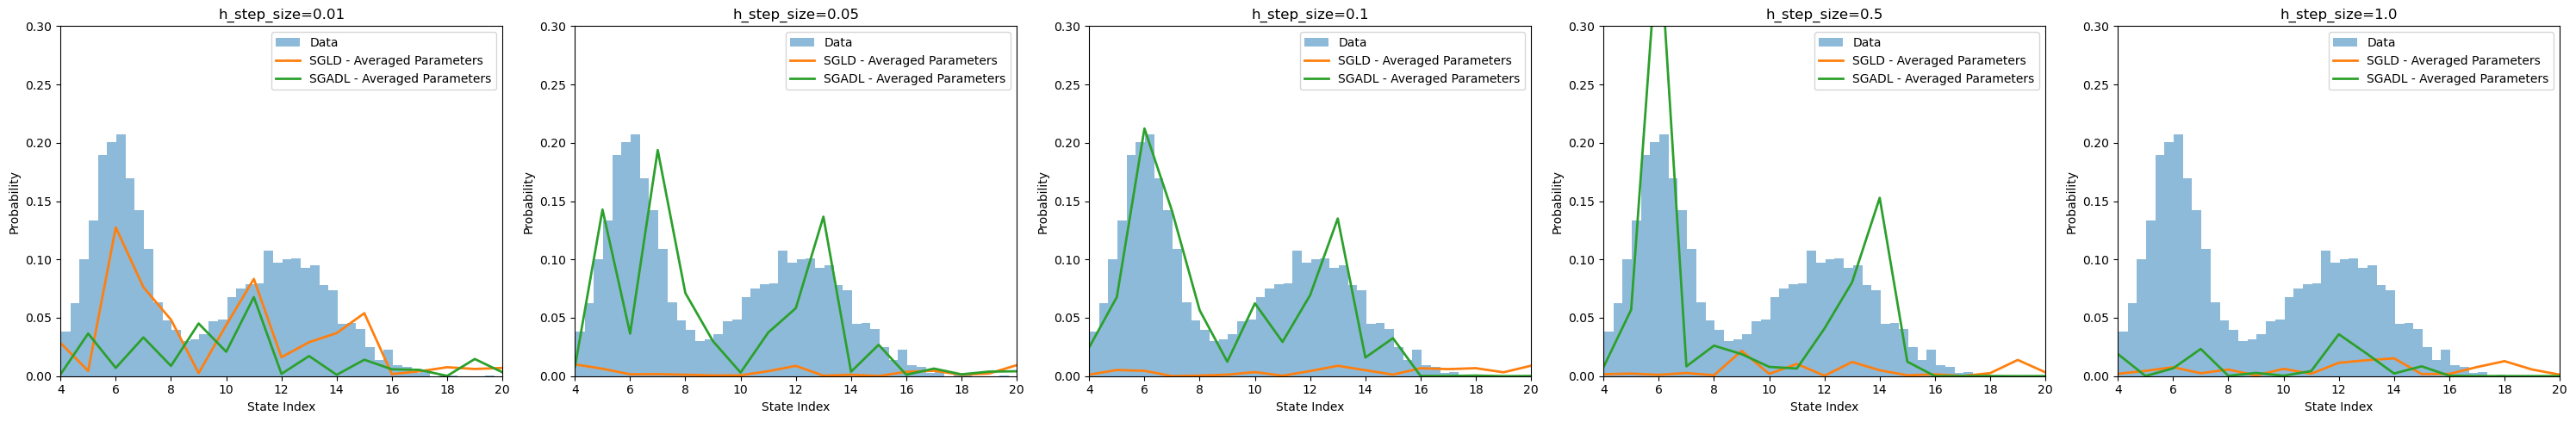

In [13]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

output_folder = "experiment_6"
h_range = [0.01, 0.05, 0.1, 0.5, 1.0]
stochastic_flag = True
qubit = 8
depth = 4
n_qubits = 8
circuit_depth = 4
beta = 100
alpha = 0
n_steps = 5000
batch_size = 200
burn_in = 1000

num_rows = len(h_range)
fig, axes = plt.subplots(1, 5,figsize=(30, 5))

for i, h_step_size in enumerate(h_range):
    filename = f"results_h_{h_step_size}.pkl"
    filepath = os.path.join(output_folder, filename)
    
    with open(filepath, 'rb') as f:
        results = pickle.load(f)
    
    ax = axes[i]
    
    # Plot histogram for data
    ax.hist(data, bins=50, density=True, alpha=0.5, label="Data")
    
    gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
    param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
    
    for model_name in ['sgld', 'sgadl']:
        params = results[model_name]['params']
        
        # Compute the averaged probabilities over the last burn_in steps
        av_probs = jnp.square(jnp.abs(param_to_st(np.array(params[-burn_in:]).mean(0)).flatten()))
        
        # Plot line for Averaged Parameters
        ax.plot(av_probs, label=f"{model_name.upper()} - Averaged Parameters", linewidth=2)
    
    ax.set_ylim(0, 0.3)
    ax.set_xlim(4, 20)
    
    ax.set_title(f'h_step_size={h_step_size}')
    ax.set_xlabel("State Index")
    ax.set_ylabel("Probability")
    ax.legend()

fig.tight_layout()
plt.show()